In [1]:
import os
os.chdir("/home/reffert/DeepAR_InfluenzaForecast")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gluonts
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.dataset.util import to_pandas
from gluonts.dataset import common
from gluonts.evaluation import make_evaluation_predictions
from PythonFiles.Configuration import Configuration
from PythonFiles.PlottingFunctions import plot_forecast_entry
from datetime import datetime

config = Configuration()
df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FurtherResearch/meningococcal.csv", sep=',')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

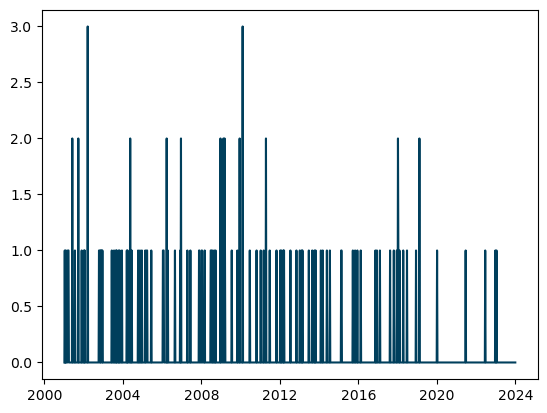

In [3]:
location = "SK München"
plt.plot((df.loc[df.location == location,:].index), df.loc[df.location == location, "value"], config.colors[0])
plt.show()

            Unnamed: 0  year  week age_group             location  value
date                                                                    
2001-01-07           0  2001     1       00+         LK Ahrweiler    0.0
2001-01-14           1  2001     2       00+         LK Ahrweiler    0.0
2001-01-21           2  2001     3       00+         LK Ahrweiler    0.0
2001-01-28           3  2001     4       00+         LK Ahrweiler    0.0
2001-02-04           4  2001     5       00+         LK Ahrweiler    0.0
...                ...   ...   ...       ...                  ...    ...
2023-12-03       21367  2023    48       00+  StädteRegion Aachen    0.0
2023-12-10       21368  2023    49       00+  StädteRegion Aachen    0.0
2023-12-17       21369  2023    50       00+  StädteRegion Aachen    0.0
2023-12-24       21370  2023    51       00+  StädteRegion Aachen    0.0
2023-12-31       21371  2023    52       00+  StädteRegion Aachen    0.0

[493200 rows x 6 columns]
            value
date  

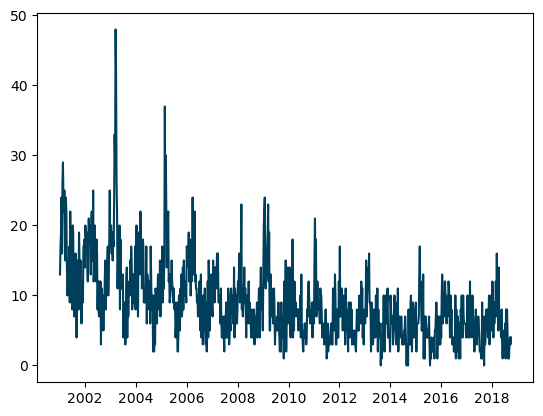

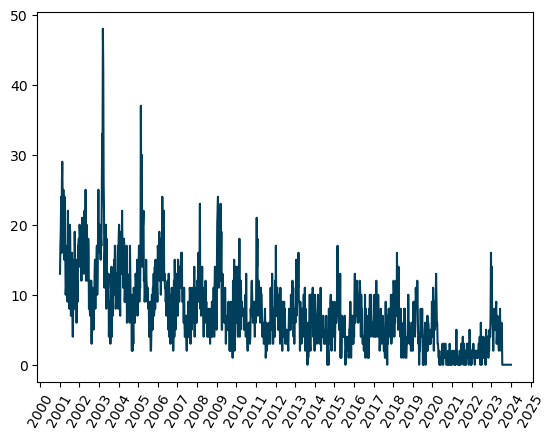

In [2]:
import matplotlib.dates as mdates

print(df)
sum_df = pd.DataFrame()
sum_df.index = df.index.unique()
for date in df.index.unique():
    sum_df.loc[sum_df.index == date,'value'] = df.loc[df.index == date]['value'].sum()
print(sum_df)
plt.plot((sum_df.loc[(sum_df.index <= config.test_end_time) & 
                 (sum_df.index >= config.train_start_time)].index),
         sum_df.loc[(sum_df.index <= config.test_end_time) &
                (sum_df.index >= config.train_start_time),'value'], config.colors[0])
plt.show()
plt.plot(sum_df.index, sum_df.value, config.colors[0])
# Setting up the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())  # Set locator to every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.xticks(rotation=60) 
plt.show()